In [1]:
from torch.utils import model_zoo
from efficientnet import *
import collections
from torch import nn
from fastai.script import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.distributed import *
from fastprogress import fastprogress
import torchvision.models as models


In [2]:
def get_data(size, woof, bs, workers=None):
    if   size<=128: path = URLs.IMAGEWOOF_160 if woof else URLs.IMAGENETTE_160
    elif size<=224: path = URLs.IMAGEWOOF_320 if woof else URLs.IMAGENETTE_320
    else          : path = URLs.IMAGEWOOF     if woof else URLs.IMAGENETTE
    path = untar_data(path)

    n_gpus = num_distrib() or 1
    if workers is None: workers = min(8, num_cpus()//n_gpus)

    return (ImageList.from_folder(path).split_by_folder(valid='val')
            .label_from_folder().transform(([flip_lr(p=0.5)], []), size=size)
            .databunch(bs=bs, num_workers=workers)
            .presize(size, scale=(0.35,1))
            .normalize(imagenet_stats))

In [3]:
data = get_data(size=300, woof=1, bs=16)
opt_func = partial(optim.Adam, betas=(0.9,0.99), eps=1e-6)

# Efficient Net Transfer Learning

In [12]:
# from https://github.com/lukemelas/EfficientNet-PyTorch  - Thank you!
url_map = {
    'efficientnetB0': 'http://storage.googleapis.com/public-models/efficientnet-b0-08094119.pth',
    'efficientnetB1': 'http://storage.googleapis.com/public-models/efficientnet-b1-dbc7070a.pth',
    'efficientnetB2': 'http://storage.googleapis.com/public-models/efficientnet-b2-27687264.pth',
    'efficientnetB3': 'http://storage.googleapis.com/public-models/efficientnet-b3-c8376fa2.pth',
}

Note the default resolution for each model

(width_coefficient, depth_coefficient, resolution, dropout_rate)

      'efficientnet-b0': (1.0, 1.0, 224, 0.2),
      'efficientnet-b1': (1.0, 1.1, 240, 0.2),
      'efficientnet-b2': (1.1, 1.2, 260, 0.3),
      'efficientnet-b3': (1.2, 1.4, 300, 0.3),
      'efficientnet-b4': (1.4, 1.8, 380, 0.4),
      'efficientnet-b5': (1.6, 2.2, 456, 0.4),
      'efficientnet-b6': (1.8, 2.6, 528, 0.5),
      'efficientnet-b7': (2.0, 3.1, 600, 0.5),

In [24]:
name = 'efficientnetB3'
m = globals()[name]()

In [25]:
#load pretrained weights
# layers are named differently
state_dict_load = model_zoo.load_url(url_map[name])
keys_new=list(state_dict_load)
keys_curr = list(m.state_dict())

state_dict_combined = collections.OrderedDict()

for i in range(len(keys_new)):
    state_dict_combined[keys_curr[i]] = state_dict_load[keys_new[i]]

    
m.load_state_dict(state_dict_combined)

In [26]:
# change the last FC layer
c_out = 10
m[-1] = nn.Linear(m[-1].in_features,c_out)

In [27]:
learn = Learner(data, m, wd=1e-5, opt_func=opt_func,metrics=[accuracy,top_k_accuracy],
             bn_wd=False, true_wd=True,
             loss_func = LabelSmoothingCrossEntropy())

In [28]:
learn.model;

In [29]:
learn.layer_groups;

In [30]:
# Pick a layer to freeze the model to
# cf learn.layer_groups
# will differ depending on which model you use

learn.freeze_to(139)  

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


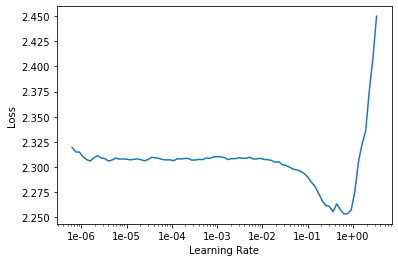

In [32]:
learn.lr_find(wd=1e-5)
learn.recorder.plot()

In [33]:
learn.fit_one_cycle(5, 5e-2,wd=1e-5, div_factor=10, pct_start=0.3)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.139333,1.708408,0.396000,0.908000,02:09
1,1.182451,1.738608,0.494000,0.886000,02:09
2,1.107218,1.241232,0.680000,0.972000,02:10
3,0.972469,0.865667,0.848000,0.998000,02:09
4,0.918214,0.816104,0.864000,0.998000,02:10


# Resnet 152 baseline

In [8]:
learn = cnn_learner(data, models.resnet152, metrics=[accuracy,top_k_accuracy],loss_func = LabelSmoothingCrossEntropy())

In [9]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


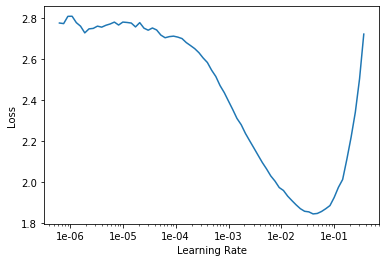

In [6]:
learn.lr_find(wd=1e-2)
learn.recorder.plot()

In [7]:
learn.fit_one_cycle(5, 3e-3,wd=1e-2, div_factor=10, pct_start=0.3)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.866613,0.900008,0.840000,0.992000,03:10
1,0.919414,0.816654,0.890000,0.986000,03:09
2,0.831210,0.721464,0.908000,0.996000,03:08
3,0.726421,0.675839,0.932000,1.000000,03:08
4,0.689786,0.686500,0.930000,0.998000,03:09
